### Day 2
#### 星系盘核分解
* 作者: 朱帅儒（394，上海天文台）

* 更新于 2022-07-28

In [28]:
import numpy as np
from scipy.signal import fftconvolve
import matplotlib
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.visualization import (
    ImageNormalize,
    LogStretch,
    LinearStretch,
    ZScaleInterval,
)
from photutils.isophote import Ellipse, EllipseGeometry

plt.rcParams["figure.constrained_layout.use"] = True

/Library/anaconda3/envs/astroconda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [13]:
class ConvolvedSersic(models.Sersic2D):
    """
    Two-dimensional Sersic surface brightness profile, convolved with
    a PSF provided by the user as a numpy array.

    See Also
    --------
    astropy.modeling.models.Sersic2D

    """

    psf = None

    @classmethod
    def set_psf(cls, psf):
        """
        Specify the PSF to be convolved with the Sersic2D model.
        """
        cls.psf = psf / np.sum(psf)  # make sure it's normalized

    @classmethod
    def evaluate(cls, x, y, amplitude, r_eff, n, x_0, y_0, ellip, theta):
        """
        Evaluate the ConvolvedSersic2D model.
        """
        z_sersic = models.Sersic2D.evaluate(
            x, y, amplitude, r_eff, n, x_0, y_0, ellip, theta
        )
        if cls.psf is None:
            raise AssertionError("Must specify PSF using set_psf method.")

        # Apparently, scipy.signal also wants double:
        return fftconvolve(np.float64(z_sersic), np.float64(cls.psf), mode="same")


### 导入数据

In [15]:
path_images = "data/HSC.fits"
path_mask = "data/HSC_mask.fits"
path_psf = "data/HSC_psf.fits"

image = fits.getdata(path_images, 1)
var = fits.getdata(path_images, 3)
mask = fits.getdata(path_mask, 0)
psf = fits.getdata(path_psf, 0)
# Convert variance to inverse rms
weight = 1/np.sqrt(var)
weight[mask == 1] = 0
# Other things
x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
nx = image.shape[1]
ny = image.shape[0]

### 单成分拟合


In [33]:
sersic_init = ConvolvedSersic(          
    amplitude=np.max(image),
    r_eff=200.0,
    n=2.0,
    x_0=358,
    y_0=350,
    ellip=0.3,
    theta=-20.0 / 180 * np.pi,
)

sersic_init.set_psf(psf)
fit_sersic = fitting.LevMarLSQFitter(calc_uncertainties=True)   
sersic_bestfit = fit_sersic(sersic_init, x, y, image, weights=weight, maxiter=1000)

1575.3800363419216
{'amplitude': 3.4257617457923177, 'r_eff': 32.176193457251486, 'n': 2.981197997614122, 'x_0': 356.54449899857707, 'y_0': 357.64700076257094, 'ellip': 0.44945133568110207, 'theta': -0.4490044583470438}


/Library/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys_r").copy()
  if __name__ == '__main__':


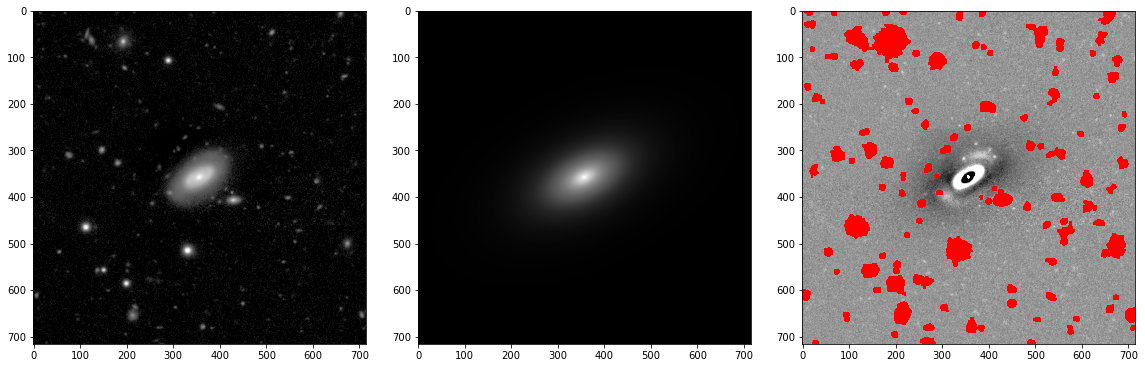

In [34]:
# 打印拟合好的参数
print(np.mean(fit_sersic.fit_info["param_cov"] / fit_sersic.fit_info["cov_x"]))
print(dict(zip(sersic_bestfit.param_names, sersic_bestfit.parameters)))
# 比较数据和模型图像
eval_sersic_bestfit = sersic_bestfit(x, y)
residual = image - eval_sersic_bestfit
residual = np.ma.array(residual, mask=mask)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
matplotlib.cm.get_cmap("Greys_r").set_bad(color="red")
norm = ImageNormalize(vmin=0, vmax=np.nanmax(image[mask == 0]), stretch=LogStretch())
resi_norm = ImageNormalize(
    residual, stretch=LinearStretch(), interval=ZScaleInterval()
)  # vmin=np.nanmin(residual), vmax=np.nanmax(residual))
axes[0].imshow(image, norm=norm, cmap="Greys_r")
axes[1].imshow(eval_sersic_bestfit, norm=norm, cmap="Greys_r")
axes[2].imshow(residual, norm=resi_norm, cmap="Greys_r")

In [35]:
data_masked = np.ma.array(image, mask=mask)
geo = EllipseGeometry(
### 比较数据图像和模型图像的亮度轮廓
    y0=sersic_bestfit.y_0.value,
    sma=sersic_bestfit.r_eff.value,
    eps=sersic_bestfit.ellip.value,
    pa=sersic_bestfit.theta.value,
)
geo.find_center(data_masked)
ellipse_data = Ellipse(data_masked, geo)
isolist_data = ellipse_data.fit_image(
    fix_center=True, maxsma=sersic_bestfit.r_eff.value * 5
)
ellipse_model = Ellipse(eval_sersic_bestfit, geo)
isolist_model = ellipse_model.fit_image(
    fix_center=True, maxsma=sersic_bestfit.r_eff.value * 5
)
print(isolist_data.to_table())
print(isolist_model.to_table())

INFO: Found center at x0 = 357.0, y0 = 358.0 [photutils.isophote.geometry]
       sma                 intens        ... niter stop_code
                                         ...                
------------------ --------------------- ... ----- ---------
               0.0    119.08555603027344 ...     0         0
0.5341327442889665    112.03411350173734 ...    10         0
0.5875460187178632    111.33100766927168 ...    10         0
0.6463006205896495    110.55963028705898 ...    10         0
0.7109306826486145    109.71411811876546 ...    10         0
 0.782023750913476    108.78825040977839 ...    10         0
0.8602261260048236    107.77598275791878 ...    10         0
 0.946248738605306     106.6706151192848 ...    10         0
1.0408736124658367    105.28847950752689 ...    10         0
1.1449609737124204    103.04814312681805 ...    10         0
               ...                   ... ...   ...       ...
 62.70229840305413    0.7607654593397335 ...    10         0
 68.972528

### 比较数据图像和模型图像的亮度轮廓

/Library/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


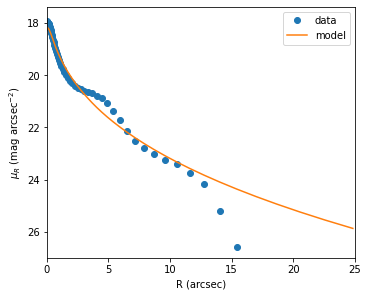

In [37]:
zpt =  27
pixel_scale = 0.168
sma_data = isolist_data.sma * pixel_scale
sma_model = isolist_model.sma * pixel_scale
mu_data = -2.5 * np.log10(isolist_data.intens / pixel_scale ** 2) + zpt
mu_model = -2.5 * np.log10(isolist_model.intens / pixel_scale ** 2) + zpt
f, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sma_data, mu_data, "o", label="data")
ax.plot(sma_model, mu_model, "-", label="model")
ax.set_xlim(0, 25)
ax.set_ylim(top=27)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("$\mu_R$ (mag arcsec$^{-2}$)")
ax.invert_yaxis()
ax.legend()

### 二成分拟合


In [73]:
# sersic模型初始化
sersic_init = ConvolvedSersic(          
    amplitude=np.max(image),
    r_eff=100,
    n=2.0,
    x_0=358,
    y_0=350,
    ellip=0.3,
    theta=-20.0 / 180 * np.pi,
)
sersic_init.set_psf(psf)
# exponential模型初始化
exp_init = ConvolvedSersic(
    amplitude=np.max(image),
    r_eff=150,
    n=1.0,                # exponential的指数应为1
    x_0=358,
    y_0=358,
    ellip=0.4,
    theta=-20.0 / 180 * np.pi,
    fixed={"n": True},    # 固定sersic指数
)
exp_init.set_psf(psf)
# 组合模型
sersicplusexp_init = sersic_init + exp_init
# 选取fitter
fit_sersicplusexp = fitting.LevMarLSQFitter(calc_uncertainties=True)
#拟合
sersicplusexp_bestfit = fit_sersicplusexp(
    sersicplusexp_init, x, y, image, weights=weight, maxiter=1000
)

1316.6047525003316
{'amplitude_0': 0.1648005919513343, 'r_eff_0': 264.54948294104537, 'n_0': 6.029860763257802, 'x_0_0': 356.5473088028197, 'y_0_0': 357.63966314757675, 'ellip_0': 0.4521681994846245, 'theta_0': -0.4515435504201631, 'amplitude_1': -0.38661740256758076, 'r_eff_1': 179.80594588958837, 'n_1': 1.0, 'x_0_1': 354.32158583842886, 'y_0_1': 358.7887526062886, 'ellip_1': 0.4414165744894731, 'theta_1': -0.40367909632651056}
standard deviations
amplitude_0| 0.082
r_eff_0    | 88.733
n_0        | 0.53
x_0_0      | 0.07
y_0_0      | 0.057
ellip_0    | 0.012
theta_0    | 0.016
amplitude_1| 0.035
r_eff_1    | 10.955
x_0_1      | 2.875
y_0_1      | 1.971
ellip_1    | 0.029
theta_1    | 0.043


/Library/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys_r").copy()


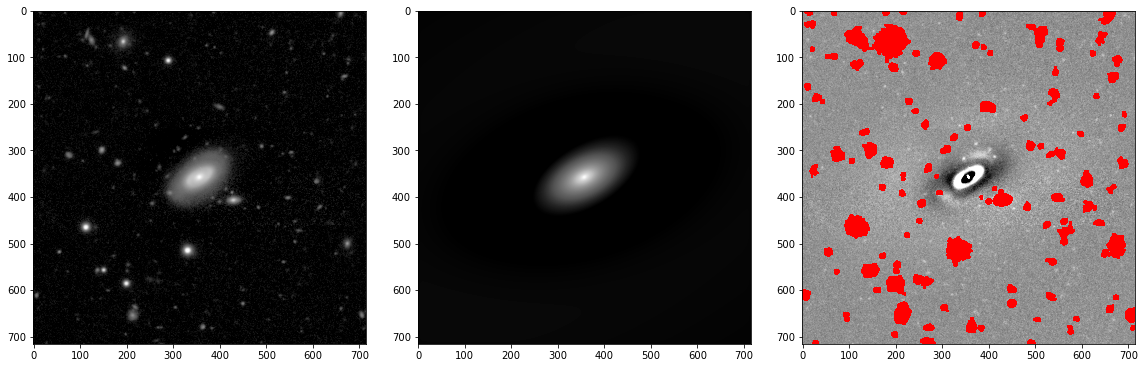

In [74]:
print(
    np.mean(
        fit_sersicplusexp.fit_info["param_cov"] / fit_sersicplusexp.fit_info["cov_x"]
    )
)
print(dict(zip(sersicplusexp_bestfit.param_names, sersicplusexp_bestfit.parameters)))
print(sersicplusexp_bestfit.stds.pprint(100, 3))

eval_sersicplusexp_bestfit = sersicplusexp_bestfit(x, y)
residual = image - eval_sersicplusexp_bestfit
residual = np.ma.array(residual, mask=mask)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
norm = ImageNormalize(vmin=0, vmax=np.nanmax(image[mask == 0]), stretch=LogStretch())
resi_norm = ImageNormalize(
    residual, stretch=LinearStretch(), interval=ZScaleInterval()
) 
matplotlib.cm.get_cmap("Greys_r").set_bad(color="red")
axes[0].imshow(image, norm=norm, cmap="Greys_r")
axes[1].imshow(eval_sersicplusexp_bestfit, norm=norm, cmap="Greys_r")
axes[2].imshow(residual, norm=resi_norm, cmap="Greys_r")

In [75]:
sersic_param = sersicplusexp_bestfit.parameters[0:7]
exp_param = sersicplusexp_bestfit.parameters[7:]
sersic_bestfit1 = ConvolvedSersic(*sersic_param)
sersic_bestfit1.set_psf(psf)
exp_bestfit1 = ConvolvedSersic(*exp_param)
exp_bestfit1.set_psf(psf)
eval_sersic_bestfit1 = sersic_bestfit1(x, y)
eval_exp_bestfit1 = exp_bestfit1(x, y)
ellipse_sersic1 = Ellipse(eval_sersic_bestfit1, geo)
isolist_sersic1 = ellipse_sersic1.fit_image(
    fix_center=True, maxsma=sersic_bestfit1.r_eff.value * 1.5
)
ellipse_exp1 = Ellipse(eval_exp_bestfit1, geo)
isolist_exp1 = ellipse_exp1.fit_image(
    fix_center=True, maxsma=exp_bestfit1.r_eff.value * 4
)
ellipse_model1 = Ellipse(eval_sersicplusexp_bestfit, geo)
isolist_model1 = ellipse_model1.fit_image(
    fix_center=True, maxsma=exp_bestfit1.r_eff.value * 4
)

/Library/anaconda3/envs/astroconda/lib/python3.7/site-packages/photutils/isophote/ellipse.py:412: AstropyUserWarning: No meaningful fit was possible.
  AstropyUserWarning)


### 比较数据图像和模型图像的亮度轮廓

/Library/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


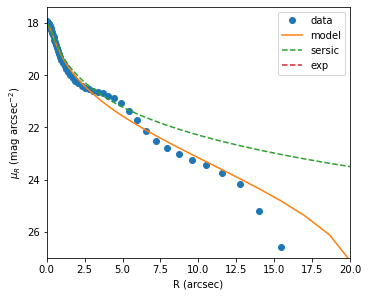

In [76]:
sma_sersic1 = isolist_sersic1.sma * pixel_scale
mu_sersic1 = (
    -2.5 * np.log10(isolist_sersic1.intens / pixel_scale ** 2) + zpt
)
sma_exp1 = isolist_exp1.sma * pixel_scale
mu_exp1 = -2.5 * np.log10(isolist_exp1.intens / pixel_scale ** 2) + zpt
sma_model1 = isolist_model1.sma * pixel_scale
mu_model1 = -2.5 * np.log10(isolist_model1.intens / pixel_scale ** 2) + zpt

f, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sma_data, mu_data, "o", label="data")
ax.plot(sma_model1, mu_model1, "-", label="model")
ax.plot(sma_sersic1, mu_sersic1, "--", label="sersic")
ax.plot(sma_exp1, mu_exp1, "--", label="exp")
ax.set_xlim(0, 20)
ax.set_ylim(top=27)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("$\mu_R$ (mag arcsec$^{-2}$)")
ax.invert_yaxis()
ax.legend()